In [14]:
# Load necessary libraries
#install.packages("factoextra")
library(tidyverse)
library(ggrepel)
library(factoextra)

In [15]:
# Read and preprocess data
Protein_expression <- read.csv("Protein_expression.csv") %>%
  mutate(UNIQUEID = paste(PATNO, EVENT_ID, sep = "-")) %>%
  select(UNIQUEID, PATNO, EVENT_ID, everything())


In [16]:
Pheno <- read.csv("Phenotype.csv") %>%
  mutate(UNIQUEID = paste(PATNO, EVENT_ID, sep = "-")) %>%
  select(UNIQUEID, COHORT, subgroup, study_status, age, SEX, race)


In [17]:
# Merge datasets
Protein_expression_pheno <- merge(Pheno, Protein_expression, by = "UNIQUEID", all.y = TRUE) %>%
  mutate(
    SEX = recode(SEX, `0` = "Male", `1` = "Female"),
    race = recode(race, `1` = "White", `2` = "Black", `3` = "Asian", `4` = "Other"),
    COHORT = recode(COHORT, `1` = "PD", `2` = "Health Control", `3` = "Swedd", `4` = "Prodromal")
  ) %>%
  filter(race == "White")

In [18]:
# Data distribution and normalization
data_dis_pivot <- Protein_expression_pheno %>%
  select(-c(subgroup, study_status, age, SEX, race, PATNO, EVENT_ID)) %>%
  pivot_longer(cols = !c("UNIQUEID", "COHORT"), names_to = "Analyte", values_to = "Value") %>%
  mutate(norm = log2(as.numeric(Value)))


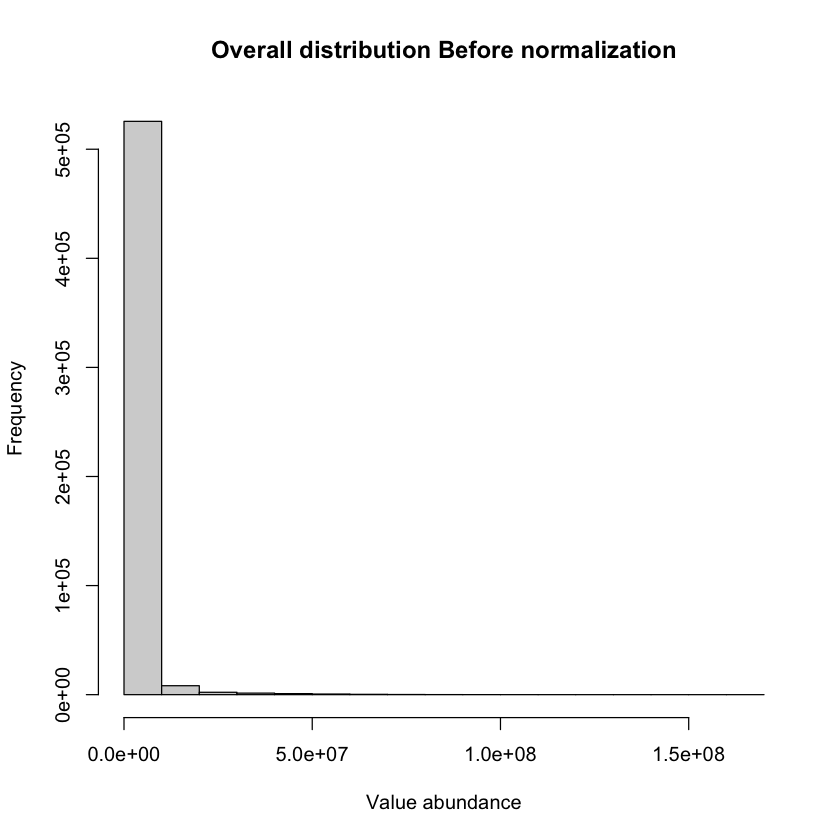

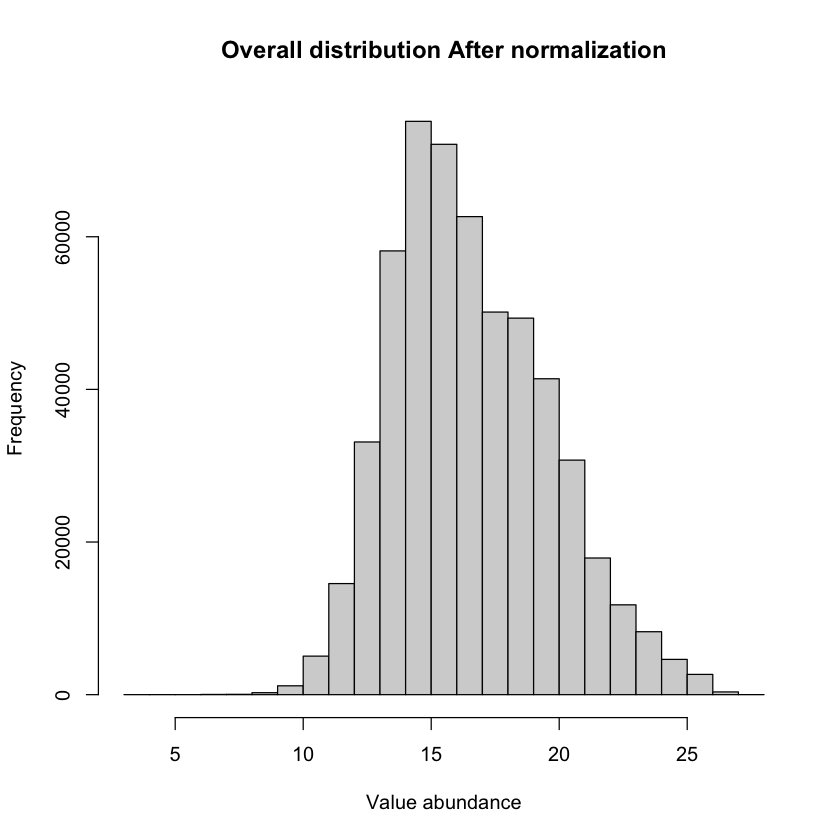

In [19]:
# Plot histograms
hist(data_dis_pivot$Value, main = "Overall distribution Before normalization", xlab = "Value abundance", ylab = "Frequency")
hist(data_dis_pivot$norm, main = "Overall distribution After normalization", xlab = "Value abundance", ylab = "Frequency")


In [24]:
# Perform PCA
Protein_expression_pca <- prcomp(Protein_expression_pheno[, 10:ncol(Protein_expression_pheno)])

Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8,

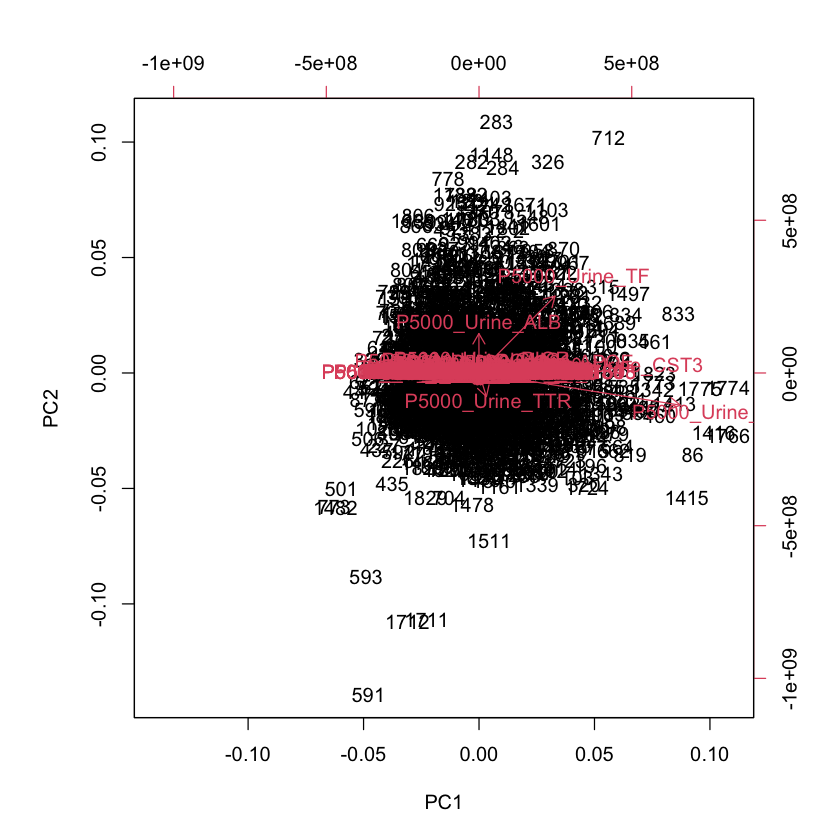

In [25]:
biplot(Protein_expression_pca)

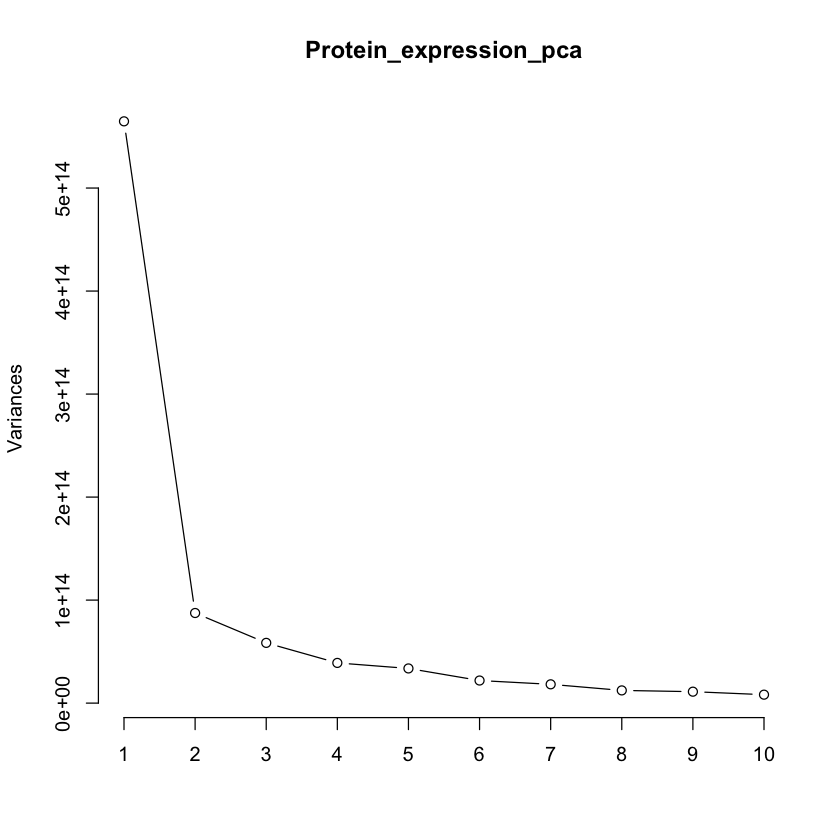

In [26]:
plot(Protein_expression_pca, type = "l")

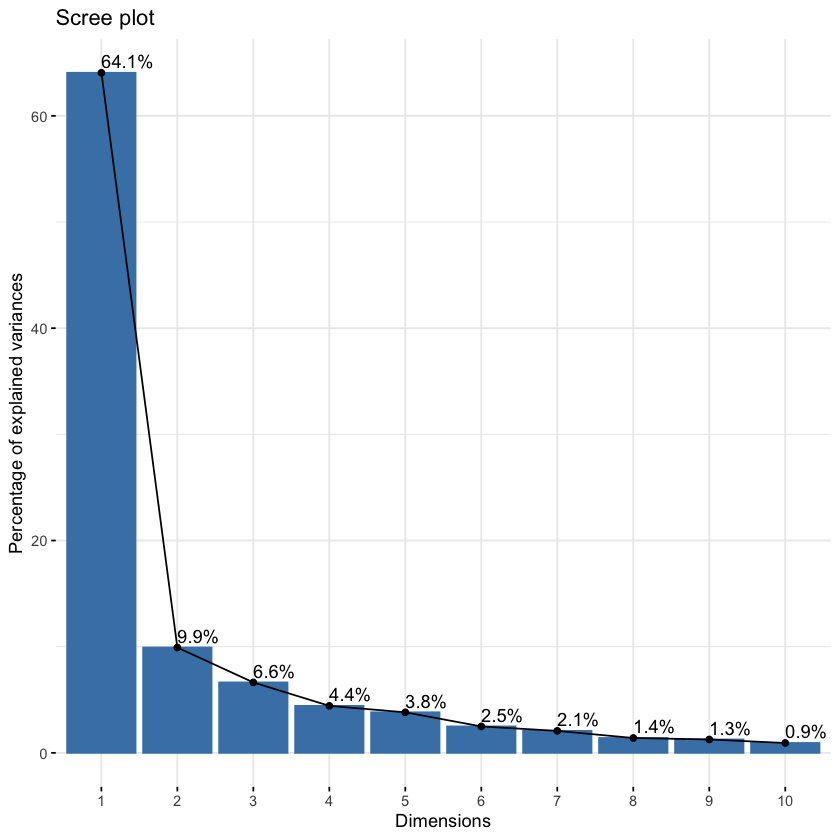

In [30]:
fviz_eig(Protein_expression_pca, addlabels = TRUE)

In [31]:
# Prepare scores and compute summary statistics
scores <- as.data.frame(Protein_expression_pca$x) %>%
  mutate(
    UNIQUEID = Protein_expression_pheno$UNIQUEID,
    EVENT_ID = Protein_expression_pheno$EVENT_ID,
    SEX = Protein_expression_pheno$SEX,
    COHORT = Protein_expression_pheno$COHORT,
    study_status = Protein_expression_pheno$study_status,
    age = Protein_expression_pheno$age
  )

In [32]:
sd_pc1 <- sd(scores$PC1)
sd_pc2 <- sd(scores$PC2)
mean_pc1 <- mean(scores$PC1)
mean_pc2 <- mean(scores$PC2)


In [33]:
# Define bounds for the standard deviation box
sd_boxes <- tibble(
  xmin = mean_pc1 - (sd_pc1 * 3),
  xmax = mean_pc1 + (sd_pc1 * 3),
  ymin = mean_pc2 - (sd_pc2 * 3),
  ymax = mean_pc2 + (sd_pc2 * 3)
)

In [34]:
# Function to perform statistical tests and plot PCA results
perform_stat_tests <- function(var, data, title_suffix) {
  data <- data %>% mutate(var = factor(get(var)))
  
  anova_result <- aov(PC1 ~ var, data = data)
  kruskal_test_result <- kruskal.test(PC1 ~ var, data = data)
  regression_result <- lm(PC1 ~ var, data = data)
  
  p1 <- ggplot(data, aes(x = PC1, y = PC2, color = var)) +
    geom_point(size = 3) +
    geom_rect(data = sd_boxes, inherit.aes = FALSE, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
              fill = NA, color = "black", linetype = "dashed") +
    labs(
      title = paste("P5000_Urine -", title_suffix),
      x = paste0("PC1 (", round(summary(Protein_expression_pca)$importance[2, 1] * 100, 2), "% variance)"),
      y = paste0("PC2 (", round(summary(Protein_expression_pca)$importance[2, 2] * 100, 2), "% variance)")
    ) +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
    annotate("text", x = Inf, y = Inf, label = paste("ANOVA p-value:", round(summary(anova_result)[[1]]["Pr(>F)"][1], 4)), 
             hjust = 1.1, vjust = 4.5, size = 4, fontface = "italic") +
    annotate("text", x = Inf, y = Inf, label = paste("Kruskal-Wallis p-value:", round(kruskal_test_result$p.value, 4)), 
             hjust = 1.1, vjust = 3, size = 4, fontface = "italic") +
    annotate("text", x = Inf, y = Inf, label = paste("Regression p-value:", round(summary(regression_result)$coefficients[2, 4], 4)), 
             hjust = 1.1, vjust = 1.5, size = 4, fontface = "italic")
  
  print(p1)
}

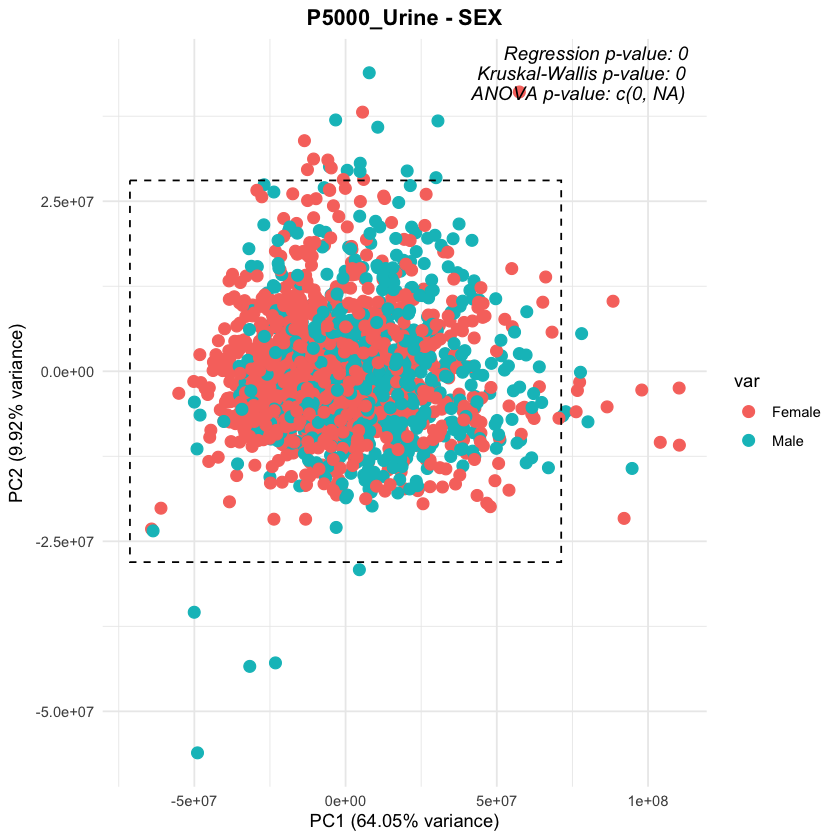

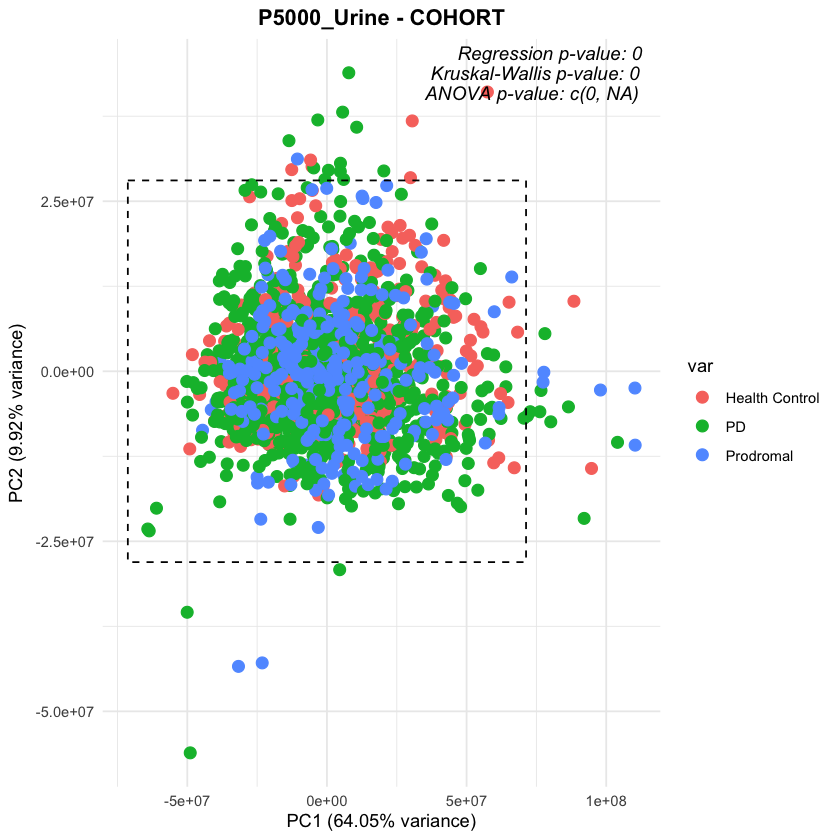

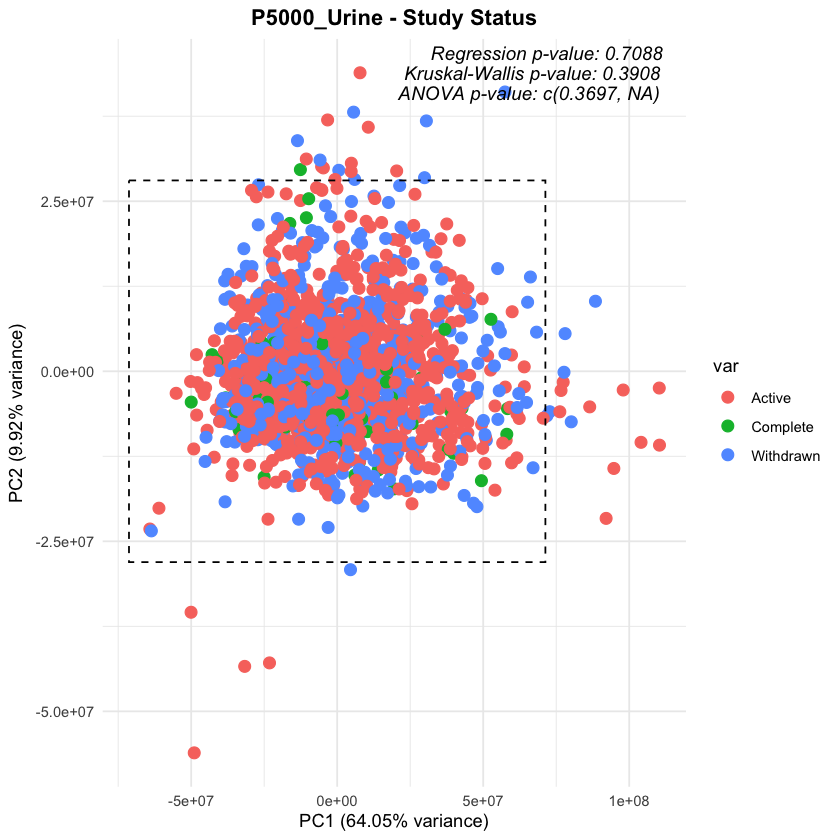

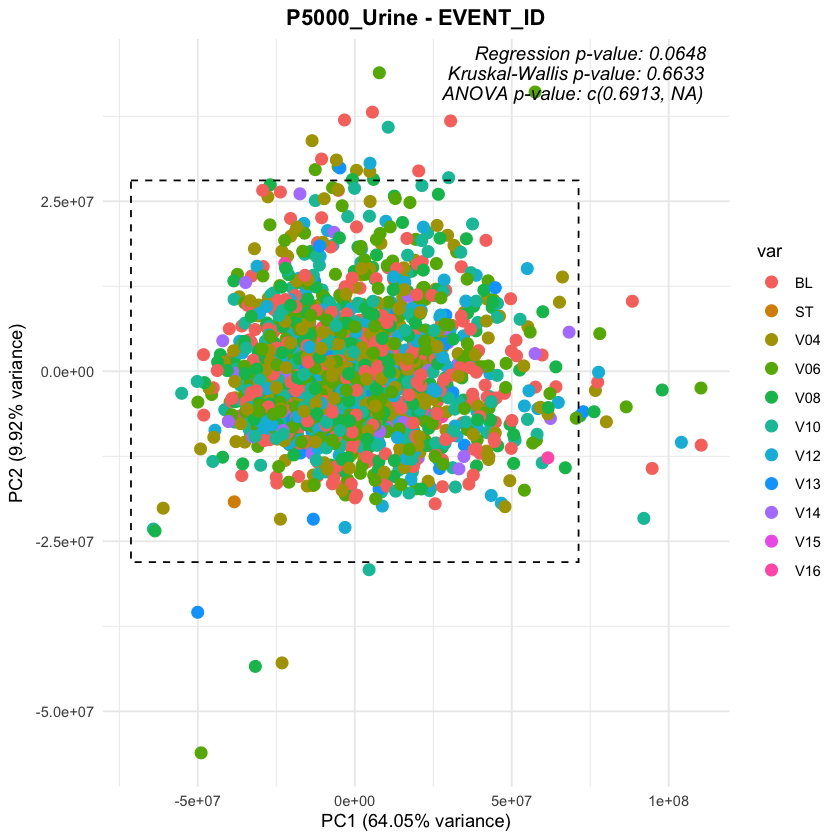

In [35]:
# Apply the function for different variables
perform_stat_tests("SEX", scores, "SEX")
perform_stat_tests("COHORT", scores, "COHORT")
perform_stat_tests("study_status", scores, "Study Status")
perform_stat_tests("EVENT_ID", scores, "EVENT_ID")

In [36]:
# Save the workspace
save.image("PCA_results.RData")